### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 6


### Дисциплина: Методы машинного обучения

##### Студент:  Матюшкин Денис Владимирович
##### Группа:   НПИбд-02-21

## Москва 2024
***

### Вариант № 8

Текст задания:
1. Набор данных stl10 с изменением разрешения до 60x90

2. Классы с метками 2,4,6,8

3. Требования к архитектуре сети MLP:

- Функциональный API при создании

- Функция потерь: разреженная категориальная кросс-энтропия

- Кол-во скрытых слоев 5

- Кол-во нейронов 70 в каждом нечетном скрытом слое, 50 в каждом четном скрытом слое

- Использование слоев с регуляризацией L2

4. Требования к архитектуре сети CNN:

- Последовательный API со списком слоев при создании

- Функция потерь: категориальная кросс-энтропия

- Кол-во сверточных слоев 2

- Количество фильтров в сверточных слоях 32

- Размеры фильтра 5х5

- Использование слоев dropout

5. Требования к архитектуре сети RNN:

- Последовательный API с методом add() при создании

- Функция потерь: разреженная категориальная кросс-энтропия

- Слой LSTM с 64 нейронами

- Использование слоев пакетной нормализации

6. Показатель качества многоклассовой классификации:

- средняя точность классов, где точность (precision) класса равна доле правильных предсказаний для всех точек, относимых классификатором к этому классу.

### Решение:

1. Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую, и валидационную и тестовую выборки. Если при дальнейшей работе с данными возникнет нехватка вычислительных ресурсов, то разрешение изображений можно уменьшить.

In [245]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import random
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [246]:
ds = tfds.load("stl10", split=['train', 'test'])
df_train = tfds.as_dataframe(ds[0])
df_test = tfds.as_dataframe(ds[1])

df_train.shape, df_test.shape

((5000, 2), (8000, 2))

In [247]:
d_test, d_validation = train_test_split(df_test, test_size=0.4, random_state=42)
df_test = pd.DataFrame(d_test)
df_validation = pd.DataFrame(d_validation)

df_train.shape, df_test.shape, df_validation.shape

((5000, 2), (4800, 2), (3200, 2))

In [248]:
df_train.head()

,image,label
0,"[[[136, 144, 153], [125, 127, 136], [125, 126,...",1
1,"[[[70, 132, 186], [81, 139, 189], [143, 176, 2...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",8
3,"[[[104, 90, 69], [101, 87, 66], [103, 88, 67],...",3
4,"[[[189, 204, 235], [189, 204, 235], [189, 204,...",9


In [249]:
df_train.iloc[0]['image'].shape

(96, 96, 3)

In [250]:
def resize_image(image):
    return tf.image.resize(image, [60, 90])

In [251]:
df_train['image'] = df_train['image'].apply(resize_image)
df_test['image'] = df_test['image'].apply(resize_image)
df_validation['image'] = df_validation['image'].apply(resize_image)

2. Оставьте в наборе изображения, указанных в индивидуальном задании, и визуализируйте несколько изображений.

In [252]:
sorted(df_train['label'].unique()), sorted(df_test['label'].unique()), sorted(df_validation['label'].unique())

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [253]:
df_train = df_train[df_train['label'].isin([2, 4, 6, 8])]
df_test = df_test[df_test['label'].isin([2, 4, 6, 8])]
df_validation = df_validation[df_validation['label'].isin([2, 4, 6, 8])]

df_train.shape, df_test.shape, df_validation.shape

((2000, 2), (1945, 2), (1255, 2))

In [254]:
sorted(df_train['label'].unique()), sorted(df_test['label'].unique()), sorted(df_validation['label'].unique())

([2, 4, 6, 8], [2, 4, 6, 8], [2, 4, 6, 8])

In [255]:
def plot_random_sample(images, n=10, num_row=2, num_col=5):
    imgs = random.sample(list(images), n)
    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    for i in range(num_row * num_col):
        img = imgs[i]
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)

    plt.tight_layout()
    plt.show()

In [256]:
df_train_images = np.array([image.numpy() / 255.0 for image in df_train['image']])

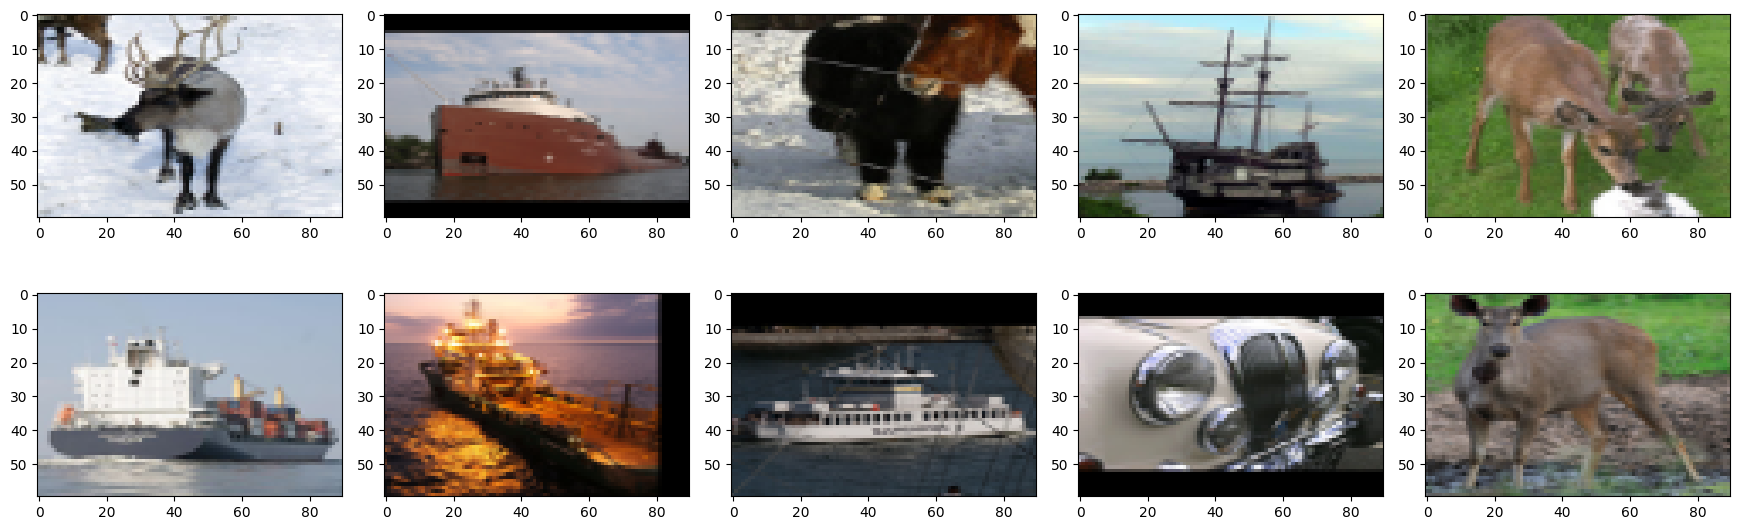

In [257]:
plot_random_sample(df_train_images)

3. Постройте нейронные сети MLP, CNN и RNN для задачи многоклассовой классификации изображений (требования к архитектуре сетей указаны в индивидуальном задании), используя функцию потерь, указанную в индивидуальном задании. Подберите такие параметры обучения, как оптимизатор, начальная скорость обучения самостоятельно, обеспечивая обучение нейронных сетей. Останавливайте обучение нейронных сетей в случае роста потерь на валидационной выборке на нескольких эпохах обучения подряд. Для каждой нейронной сети выведите количество потребовавшихся эпох обучения.

In [258]:
label_mapping = {2: 0, 4: 1, 6: 2, 8: 3}
train_labels = df_train['label'].map(label_mapping).to_numpy(dtype=np.float32)
test_labels = df_test['label'].map(label_mapping).to_numpy(dtype=np.float32)
validation_labels = df_validation['label'].map(label_mapping).to_numpy(dtype=np.float32)

train_labels.shape, test_labels.shape, validation_labels.shape

((2000,), (1945,), (1255,))

In [259]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto', sparse=False)

train_labels_one_hot = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_one_hot = encoder.transform(test_labels.reshape(-1, 1))
validation_labels_one_hot = encoder.transform(validation_labels.reshape(-1, 1))

train_labels_one_hot.shape, test_labels_one_hot.shape, validation_labels_one_hot.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((2000, 4), (1945, 4), (1255, 4))

In [260]:
train_images = np.array([image.numpy() / 255.0 for image in df_train['image']])
test_images = np.array([image.numpy() / 255.0 for image in df_test['image']])
validation_images = np.array([image.numpy() / 255.0 for image in df_validation['image']])

train_images.shape, test_images.shape, validation_images.shape

((2000, 60, 90, 3), (1945, 60, 90, 3), (1255, 60, 90, 3))

In [261]:
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0
validation_images = validation_images.astype(np.float32) / 255.0

train_images.shape, test_images.shape, validation_images.shape

((2000, 60, 90, 3), (1945, 60, 90, 3), (1255, 60, 90, 3))

Нейронная сеть MLP:

In [262]:
inputs = tf.keras.Input(shape=(60, 90, 3))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(70, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(70, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(70, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model_mlp = tf.keras.Model(inputs, outputs)

model_mlp.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [244]:
history_mlp = model_mlp.fit(
    train_images, train_labels,
    epochs=100,
    batch_size=128,
    validation_data=(validation_images, validation_labels),
    callbacks=[callback]
)
print(f"MLP модель обучалась {len(history_mlp.history['loss'])} эпох.")

Epoch 1/100
16/16 [==============================] - 4s 52ms/step - loss: 4.4059 - accuracy: 0.3925 - val_loss: 3.6619 - val_accuracy: 0.4701
Epoch 2/100
16/16 [==============================] - 0s 25ms/step - loss: 3.3217 - accuracy: 0.5530 - val_loss: 2.9958 - val_accuracy: 0.6319
Epoch 3/100
16/16 [==============================] - 0s 26ms/step - loss: 2.8284 - accuracy: 0.6075 - val_loss: 2.6157 - val_accuracy: 0.6430
Epoch 4/100
16/16 [==============================] - 0s 25ms/step - loss: 2.5499 - accuracy: 0.6150 - val_loss: 2.4067 - val_accuracy: 0.6614
Epoch 5/100
16/16 [==============================] - 0s 25ms/step - loss: 2.3197 - accuracy: 0.6295 - val_loss: 2.2499 - val_accuracy: 0.6319
Epoch 6/100
16/16 [==============================] - 0s 25ms/step - loss: 2.1200 - accuracy: 0.6415 - val_loss: 2.0649 - val_accuracy: 0.6382
Epoch 7/100
16/16 [==============================] - 0s 22ms/step - loss: 1.9985 - accuracy: 0.6515 - val_loss: 1.9709 - val_accuracy: 0.6438
Epoch 

In [263]:
def plot_loss(history, title):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

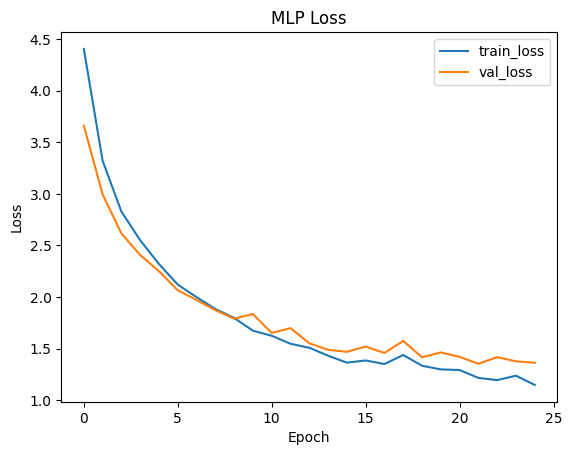

In [264]:
plot_loss(history_mlp, "MLP Loss")

Нейронная сеть CNN:

In [265]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(60, 90, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_cnn.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [266]:
history_cnn = model_cnn.fit(
    train_images, train_labels_one_hot,
    epochs=100,
    batch_size=128,
    validation_data=(validation_images, validation_labels_one_hot),
    callbacks=[callback]
)

print(f"CNN модель обучалась {len(history_cnn.history['loss'])} эпох.")

Epoch 1/100
16/16 [==============================] - 3s 78ms/step - loss: 1.3846 - accuracy: 0.2870 - val_loss: 1.3734 - val_accuracy: 0.2876
Epoch 2/100
16/16 [==============================] - 1s 37ms/step - loss: 1.3329 - accuracy: 0.3575 - val_loss: 1.2517 - val_accuracy: 0.4685
Epoch 3/100
16/16 [==============================] - 1s 39ms/step - loss: 1.2007 - accuracy: 0.4385 - val_loss: 1.1178 - val_accuracy: 0.5084
Epoch 4/100
16/16 [==============================] - 1s 34ms/step - loss: 1.1203 - accuracy: 0.4955 - val_loss: 1.0812 - val_accuracy: 0.5402
Epoch 5/100
16/16 [==============================] - 0s 29ms/step - loss: 1.0837 - accuracy: 0.5115 - val_loss: 1.0540 - val_accuracy: 0.5610
Epoch 6/100
16/16 [==============================] - 1s 34ms/step - loss: 1.0587 - accuracy: 0.5385 - val_loss: 1.0394 - val_accuracy: 0.5745
Epoch 7/100
16/16 [==============================] - 1s 33ms/step - loss: 1.0386 - accuracy: 0.5495 - val_loss: 1.0065 - val_accuracy: 0.5992
Epoch 

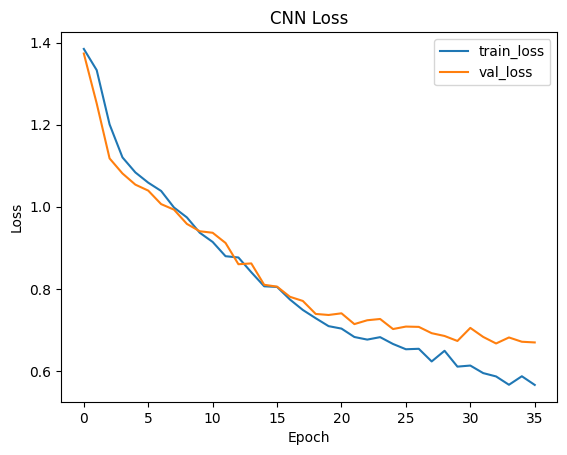

In [267]:
plot_loss(history_cnn, "CNN Loss")

Нейронная сеть RNN:

In [293]:
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Flatten(input_shape=(60, 90, 3)))
model_rnn.add(tf.keras.layers.Reshape((60, 90*3)))
model_rnn.add(tf.keras.layers.LSTM(64, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_rnn.add(tf.keras.layers.BatchNormalization())
model_rnn.add(tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [294]:
history_rnn = model_rnn.fit(
    train_images, train_labels,
    epochs=100,
    batch_size=128,
    validation_data=(validation_images, validation_labels),
    callbacks=[callback]
)

print(f"RNN модель обучалась {len(history_rnn.history['loss'])} эпох.")

Epoch 1/100
16/16 [==============================] - 6s 100ms/step - loss: 3.7721 - accuracy: 0.3915 - val_loss: 3.5638 - val_accuracy: 0.2462
Epoch 2/100
16/16 [==============================] - 0s 29ms/step - loss: 3.2259 - accuracy: 0.3880 - val_loss: 3.1293 - val_accuracy: 0.2462
Epoch 3/100
16/16 [==============================] - 0s 27ms/step - loss: 2.7808 - accuracy: 0.4275 - val_loss: 2.7752 - val_accuracy: 0.2470
Epoch 4/100
16/16 [==============================] - 0s 30ms/step - loss: 2.3712 - accuracy: 0.4965 - val_loss: 2.4858 - val_accuracy: 0.2478
Epoch 5/100
16/16 [==============================] - 0s 26ms/step - loss: 2.0341 - accuracy: 0.5375 - val_loss: 2.2899 - val_accuracy: 0.2470
Epoch 6/100
16/16 [==============================] - 0s 30ms/step - loss: 1.8102 - accuracy: 0.5470 - val_loss: 2.1305 - val_accuracy: 0.2470
Epoch 7/100
16/16 [==============================] - 0s 29ms/step - loss: 1.6289 - accuracy: 0.5705 - val_loss: 1.9990 - val_accuracy: 0.2470
Epoch

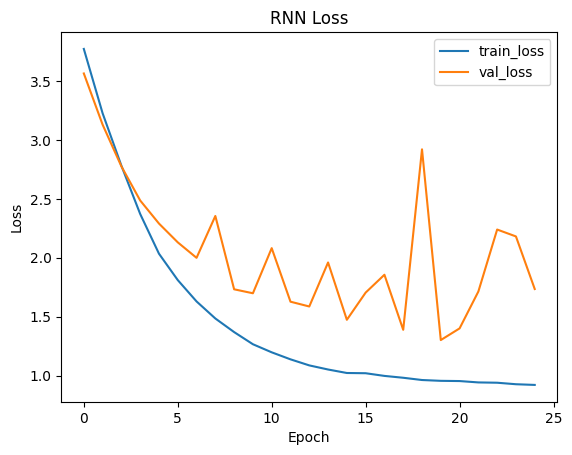

In [295]:
plot_loss(history_rnn, "RNN Loss")

Использовал слои с регуляризацией L2, чтобы сеть обучалась нормально.

4. Оцените качество многоклассовой классификации нейронными сетями MLP, CNN и RNN на тестовой выборке при помощи показателя качества, указанного в индивидуальном задании, и выведите архитектуру нейронной сети с лучшим качеством.

In [298]:
loss_mlp, accuracy_mlp = model_mlp.evaluate(test_images, test_labels)
loss_cnn, accuracy_cnn = model_cnn.evaluate(test_images, test_labels_one_hot)
loss_rnn, accuracy_rnn = model_rnn.evaluate(test_images, test_labels)

print("MLP: Точность на тестовой выборке =", accuracy_mlp)
print("CNN: Точность на тестовой выборке =", accuracy_cnn)
print("RNN: Точность на тестовой выборке =", accuracy_rnn)

61/61 [==============================] - 0s 6ms/step - loss: 1.3015 - accuracy: 0.5188
MLP: Точность на тестовой выборке = 0.28380462527275085
CNN: Точность на тестовой выборке = 0.7367609143257141
RNN: Точность на тестовой выборке = 0.5187660455703735


In [299]:
best_accuracy = max(accuracy_mlp, accuracy_cnn, accuracy_rnn)

if best_accuracy == accuracy_mlp:
    print(f"Модель с лучшей точностью: MLP ({best_accuracy})")
elif best_accuracy == accuracy_cnn:
    print(f"Модель с лучшей точностью: CNN ({best_accuracy})")
else:
    print(f"Модель с лучшей точностью: RNN ({best_accuracy})")

Модель с лучшей точностью: CNN (0.7367609143257141)


5. Визуализируйте кривые обучения трех построенных моделей для показателя потерь на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду. Используйте для визуализации относительные потери (потери, деленные на начальную потери на первой эпохе).

In [307]:
def epochs(history):
  return range(1, len(history.history['val_loss']) + 1)

In [315]:
epochs_mlp = epochs(history_mlp)
epochs_cnn = epochs(history_cnn)
epochs_rnn = epochs(history_rnn)

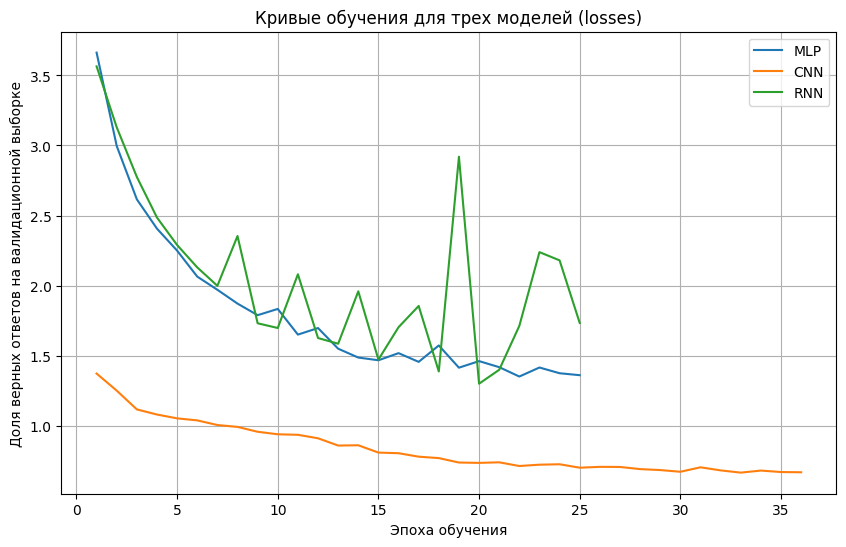

In [321]:
plt.figure(figsize=(10, 6))

plt.plot(epochs_mlp, history_mlp.history['val_loss'], label='MLP')
plt.plot(epochs_cnn, history_cnn.history['val_loss'], label='CNN')
plt.plot(epochs_rnn, history_rnn.history['val_loss'], label='RNN')

plt.title('Кривые обучения для трех моделей (losses)')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов на валидационной выборке')
plt.legend()
plt.grid(True)
plt.show()

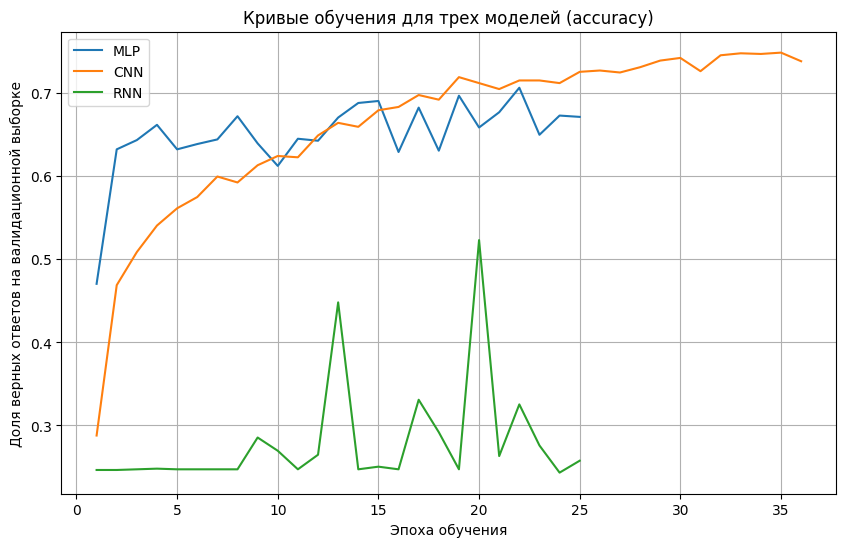

In [322]:
plt.figure(figsize=(10, 6))

plt.plot(epochs_mlp, history_mlp.history['val_accuracy'], label='MLP')
plt.plot(epochs_cnn, history_cnn.history['val_accuracy'], label='CNN')
plt.plot(epochs_rnn, history_rnn.history['val_accuracy'], label='RNN')

plt.title('Кривые обучения для трех моделей (accuracy)')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов на валидационной выборке')
plt.legend()
plt.grid(True)
plt.show()

7. Для каждого из классов определите два изображения в тестовой выборке, имеющее минимальную и максимальную вероятности классификации в правильный класс, и визуализируйте эти изображения

In [336]:
test_images = np.array([image.numpy() / 255.0 for image in df_test['image']])

61/61 [==============================] - 0s 3ms/step


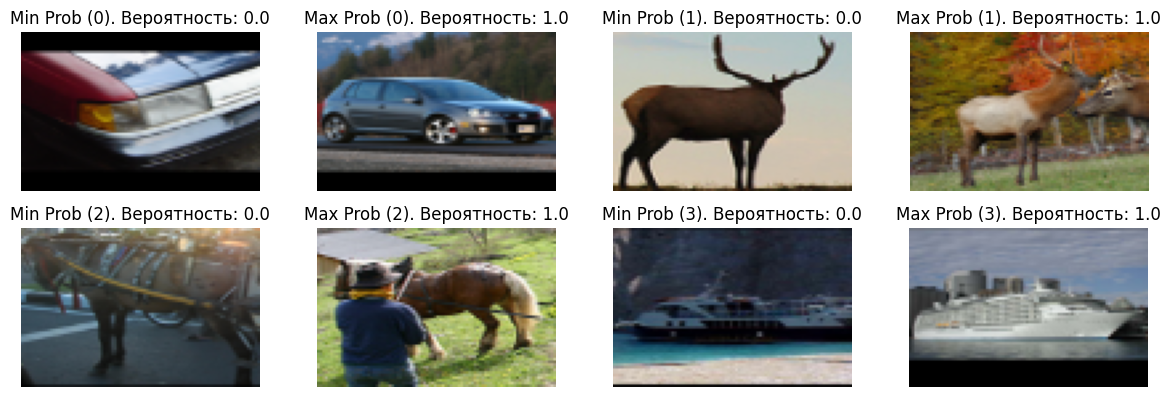

In [341]:
predictions_cnn = model_cnn.predict(test_images)
min_indices = {label: None for label in range(4)}
max_indices = {label: None for label in range(4)}

for i, (prediction, true_label) in enumerate(zip(predictions_cnn, test_labels)):
    true_label = int(true_label)
    if min_indices[true_label] is None or prediction[true_label] < predictions_cnn[min_indices[true_label]][true_label]:
        min_indices[true_label] = i
    if max_indices[true_label] is None or prediction[true_label] > predictions_cnn[max_indices[true_label]][true_label]:
        max_indices[true_label] = i

plt.figure(figsize=(12, 8))
for label in range(4):
    plt.subplot(4, 4, 2 * label + 1)
    plt.imshow(test_images[min_indices[label]])
    plt.title(f'Min Prob ({label}). Вероятность: {predictions_cnn[min_indices[label]][label]}')
    plt.axis('off')

    plt.subplot(4, 4, 2 * label + 2)
    plt.imshow(test_images[max_indices[label]])
    plt.title(f'Max Prob ({label}). Вероятность: {predictions_cnn[max_indices[label]][label]}')
    plt.axis('off')
plt.tight_layout()
plt.show()
